<a href="https://colab.research.google.com/github/kurukku213/anomaly_detection_auto_encoder/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
AutoEncoderで異常検知を実装してみる
"""

import numpy as np
import glob
import csv
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader, random_split

seed = 0

# シードを固定するための関数
def torch_fix_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

torch_fix_seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [ ]:
"""
Googleドライブのマウント
"""

### 名前によって変更
sensor_name = "センサD"
model_name = "sensorD"

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
データを取得してテンソルに変換
"""

normal_folder = Path(f"/content/drive/MyDrive/CSV/{sensor_name}正常")
anomaly_folder = [Path(f"/content/drive/MyDrive/CSV/{sensor_name}異物1"),
                  Path(f"/content/drive/MyDrive/CSV/{sensor_name}異物2"),
                  Path(f"/content/drive/MyDrive/CSV/{sensor_name}異物2")]

normal_data = []
for file in normal_folder.glob("**/*.csv"):
    df = pd.read_csv(file)
    acceleration = df["acceleration"].astype(float).to_list()
    normal_data.append(acceleration)

anomaly_data = []
for folder in anomaly_folder:
    for file in folder.glob("**/*.csv"):
        df = pd.read_csv(file)
        acceleration = df["acceleration"].astype(float).to_list()
        anomaly_data.append(acceleration)

normal_data = torch.tensor(normal_data)
anomaly_data = torch.tensor(anomaly_data)

input_dim = normal_data.shape[1]
normal_row = normal_data.shape[0]
anomaly_row = anomaly_data.shape[0]

In [ ]:
# オートエンコーダの定義
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        # エンコーダ
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        # デコーダ
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
"""
テンソルと関数の定義
"""

# GPUを使用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# テストデータと訓練データ
test_data = torch.cat((normal_data, anomaly_data), dim=0)
train_data = normal_data

# 正常: 0, 異常: 1
labels = torch.cat((torch.zeros(normal_row), torch.ones(anomaly_row)), dim=0)

# データローダの準備
train_loader = DataLoader(train_data,
                          batch_size=64,
                          shuffle=True,
                          num_workers=2,
                          worker_init_fn=seed_worker,
                          generator=g)

# モデル、損失関数、最適化
model = AutoEncoder(input_dim=input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

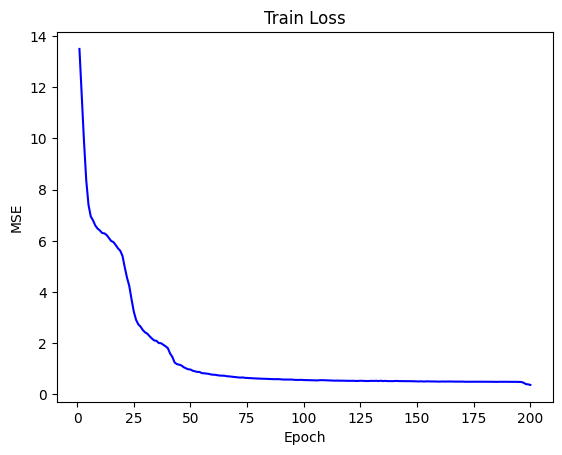

In [ ]:
"""
学習と異常度の導出
"""

epochs = 200
train_loss_list = []  # 学習損失（MSE）

# モデルの学習
for epoch in range(epochs):
  model.train()
  train_loss = 0

  for inputs in train_loader:
    inputs = inputs.to(device)

    # 順伝播
    outputs = model(inputs)

    # 再構成誤差の計算
    loss = criterion(outputs, inputs)

    # ミニバッチごとの損失を蓄積
    train_loss += loss.item()

    # 逆伝播とパラメータ更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # ミニバッチの平均の損失を計算
  batch_train_loss = train_loss / len(train_loader)
  train_loss_list.append(batch_train_loss)

# 損失（MSE）
plt.figure()
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot(range(1, epochs+1), train_loss_list, color="blue",
         linestyle="-", label="Train_Loss")
# 表示
plt.show()

# テストデータで評価
model.eval()
anomaly_score = []
with torch.no_grad():
  for data in test_data:
    data = data.to(device)
    sample = model(data)
    loss = criterion(data, sample)
    anomaly_score.append(round(loss.item(), 3))

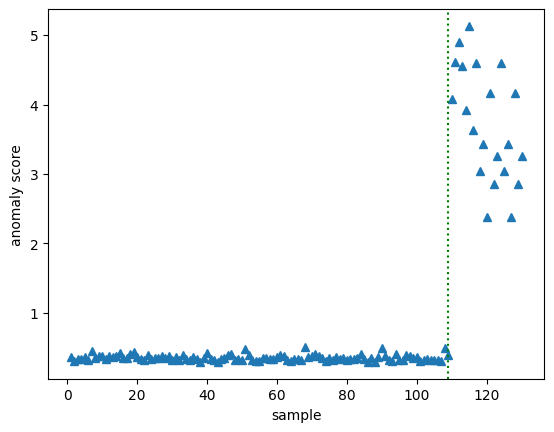

In [ ]:
"""
異常度の可視化
"""

plt.figure()
plt.xlabel("sample")
plt.ylabel("anomaly score")
plt.plot(range(1, len(anomaly_score)+1), anomaly_score, "^")

# 正常と異常の境目
plt.axvline(normal_row, color="green", linestyle=":")

# 閾値
#plt.axhline(2.384, color="red")

# 表示
plt.show()

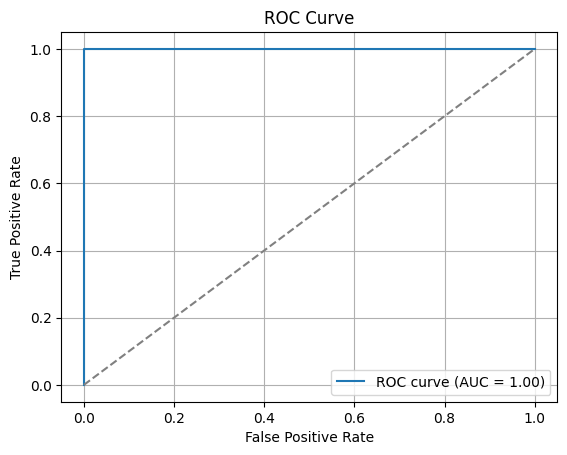

AUC: 1.0000


In [ ]:
"""
ROC曲線とAUCの計算
"""

fpr, tpr, thresholds = roc_curve(labels.numpy(), anomaly_score)
auc = roc_auc_score(labels.numpy(), anomaly_score)

# ROC曲線のプロット
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

print(f"AUC: {auc:.4f}")

In [ ]:
"""
閾値の決定
"""

# Youden's Index
youden_index = tpr - fpr
optimal_idx_youden = youden_index.argmax()
optimal_threshold_youden = thresholds[optimal_idx_youden]

print(f"Optimal Threshold (Youden's Index): {optimal_threshold_youden}")

Optimal Threshold (Youden's Index): 2.384


In [ ]:
"""
最終的な評価
"""

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

predict = []

for score in anomaly_score:
  if score > optimal_threshold_youden:
    # 異常と判定
    predict.append(1)
  else:
    # 正常と判定
    predict.append(0)

print("正解率", accuracy_score(labels.numpy(), predict))
print("適合率", precision_score(labels.numpy(), predict))
print("再現率", recall_score(labels.numpy(), predict))

tn, fp, fn, tp = confusion_matrix(labels.numpy(), predict).ravel()
print("True Positive Rate (TPR):", tp / (tp + fn))
print("False Positive Rate (FPR):", fp / (fp + tn))

print("混同行列")
print(confusion_matrix(labels.numpy(), predict))

正解率 0.9846153846153847
適合率 1.0
再現率 0.9047619047619048
True Positive Rate (TPR): 0.9047619047619048
False Positive Rate (FPR): 0.0
混同行列
[[109   0]
 [  2  19]]


In [ ]:
# modelの保存

torch.save(model, f"/content/drive/MyDrive/{model_name}.pth")